# GlucoGuard: Diabetes Risk Prediction Model

## Overview
**"GlucoGuard"** is a data-driven Machine Learning model designed to predict the risk of developing diabetes in its early stages. It assists healthcare professionals in diagnosis and management.

## Key Features
- **Environment Setup**: Run `pip install -r requirements.txt` to install necessary dependencies.
- **Dataset**: Utilizes the [Early Stage Diabetes Risk Prediction Dataset (2020)](https://doi.org/10.24432/C5VG8H) from the UCI Machine Learning Repository.
- **Models Directory**: Trained models are stored in the [`./models/`](./models/) directory for reference and use.

## Getting Started
Each section of this notebook is dedicated to a specific aspect of the machine learning pipeline, including data preprocessing steps like normalization and feature encoding, model training, and evaluation. Detailed explanations and visualizations are provided to facilitate understanding and insight into the model's performance.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, \
    classification_report, roc_curve, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
from models.demo import *


## 1. Data Preprocessing

### 1.1 Outliers detection

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

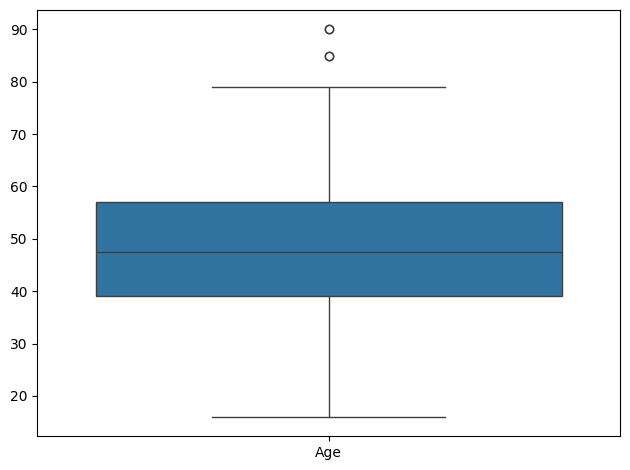

In [2]:
df = pd.read_csv("data/diabetes_data_upload.csv", delimiter=',')

X = df.drop(columns='class', axis=1).to_numpy()
y = df['class'].to_numpy()

df.info()
sns.boxplot(data=df)
plt.tight_layout()
plt.show()


### 1.2 Feature/Label Engineering for Visualization
- Normalization
- Feature Encoding

In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(feature_range=(0, 1)), slice(0, 1)),
        ('cat', OneHotEncoder(), slice(1, None))
    ])

X_encoded = preprocessor.fit_transform(X)


### 1.3 Data Visualization

#### 1.3.1 Correlation Matrix

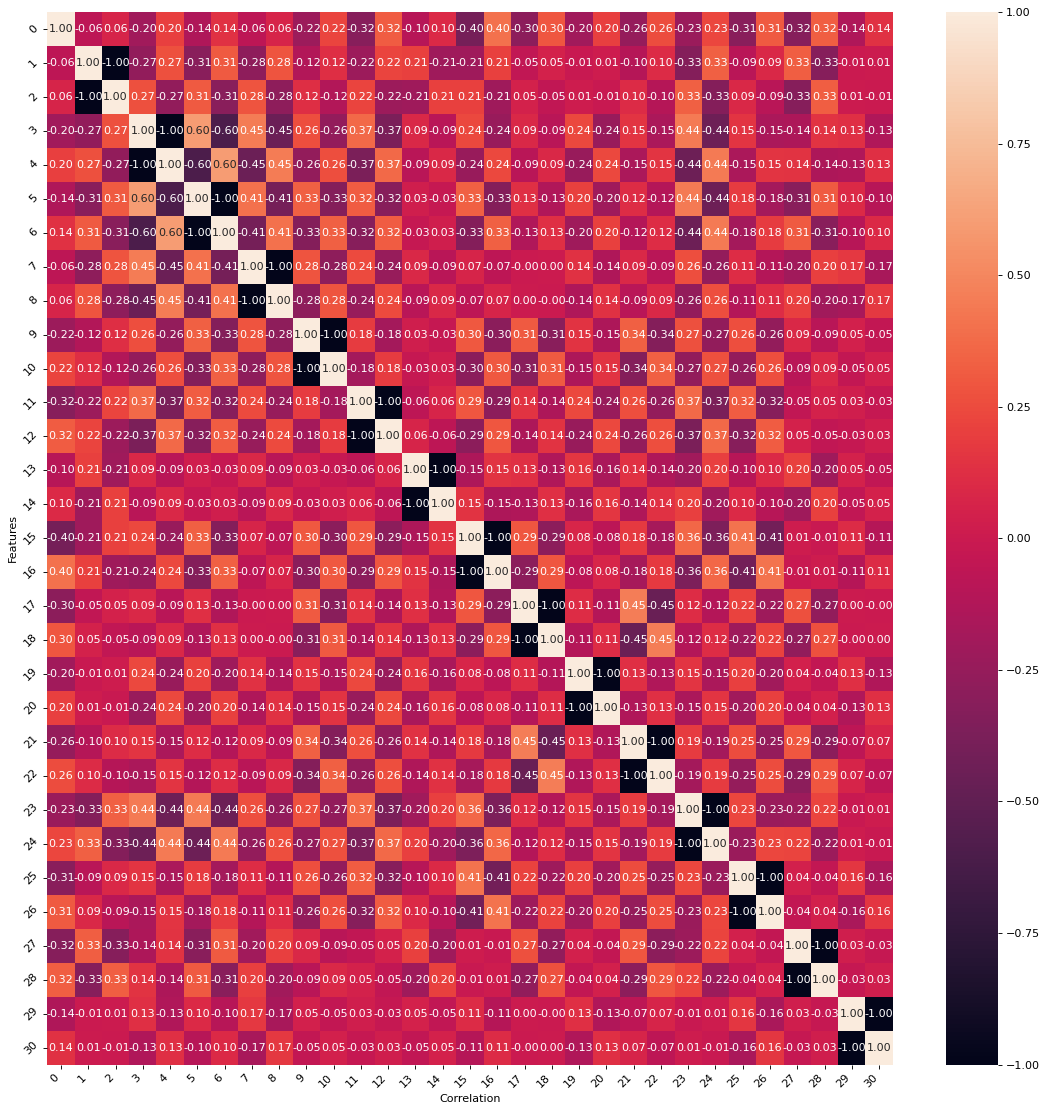

In [4]:
plt.figure(figsize=(14, 14), dpi=80)
corr_matrix = pd.DataFrame(X_encoded).corr() \
    .rename_axis('Features') \
    .rename_axis('Correlation', axis=1)
sns.heatmap(data=corr_matrix, annot=True, fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


## 2. Model Training
1. Logistic Regression (Baseline)
2. Support Vector Machine Classifier
   - Linear Kernel
   - Polynomial Kernel

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
    )

### 2.1 Baseline Logistic Regression Model

In [6]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(
    f"Model Accuracy with 1000 max_iters for lr: \
    {accuracy_score(y_test, y_pred_lr)}"
    )

Model Accuracy with 1000 max_iters for lr:     0.9230769230769231


### 2.2 SVM Classifier Model
1. SVC with Linear Kernel
2. SVC with Polynomial Kernel

In [7]:
def train_and_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

models = {
    'linear': {'model': SVC(kernel="linear", probability=True), 'accu': {}, 'pred': {}},
    'poly': {'model': SVC(kernel="poly", probability=True), 'accu': {}, 'pred': {}}
}

In [9]:
for i in tqdm(range(1, 150)):
    for model_name, model_info in models.items():
        model_info['model'].C = i
        accuracy, y_pred = train_and_score(model_info['model'], X_train, y_train, X_test, y_test)
        model_info['accu'][i] = accuracy
        model_info['pred'][i] = y_pred

for model_name, model_info in models.items():
    Cmax = max(model_info['accu'], key=lambda k: model_info['accu'][k])
    print(f"Accuracy for {model_name} kernal with C = {Cmax}, (max score) {model_info['accu'][Cmax]:0.4f}")


100%|██████████| 149/149 [00:30<00:00,  4.86it/s]

Accuracy for linear kernal with C = 4, (max score) 0.9423
Accuracy for poly kernal with C = 1, (max score) 0.9904


## 3. Model Evaluation

### 3.1 Confusion Matrix

In [10]:
def plot_cm(cm, title, ax):
    cm_df = pd.DataFrame(
        data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
        index=['Predict Positive:1', 'Predict Negative:0']
    )
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu', ax=ax)
    ax.set_title(title)
    

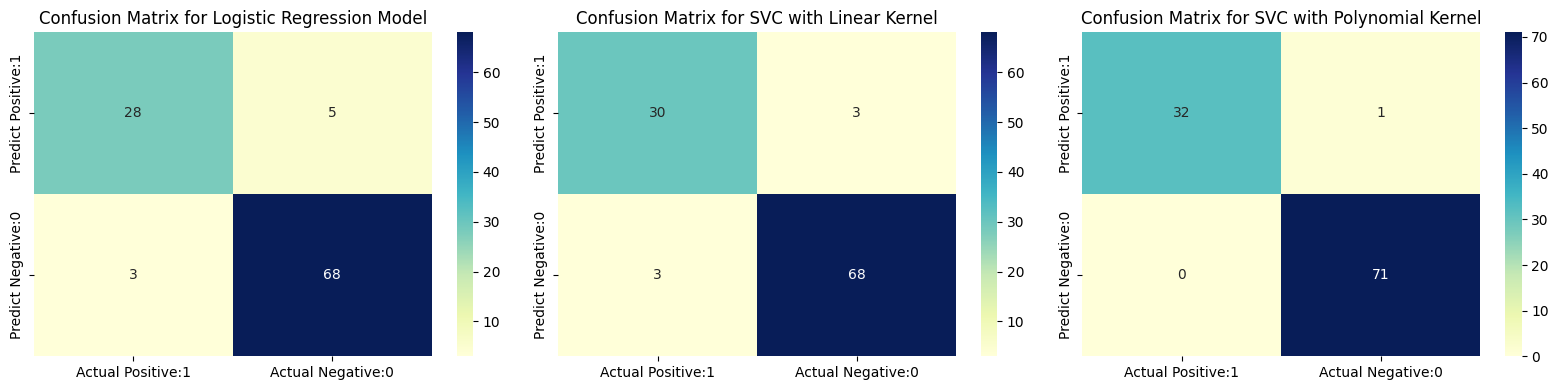

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

y_pred_lin = models['linear']['pred'][max(models['linear']['accu'], key=models['linear']['accu'].get)]
y_pred_polyn = models['poly']['pred'][max(models['poly']['accu'], key=models['poly']['accu'].get)]

model_predictions = [
    (y_pred_lr, "Confusion Matrix for Logistic Regression Model"),
    (y_pred_lin, "Confusion Matrix for SVC with Linear Kernel"),
    (y_pred_polyn, "Confusion Matrix for SVC with Polynomial Kernel")
]

for i, (y_pred, title) in enumerate(model_predictions):
    plot_cm(confusion_matrix(y_test, y_pred), title, axs[i])

plt.tight_layout()
plt.show()


### 3.2 Classification Report

In [12]:
model_predictions = {
    'Linear SVM': y_pred_lin,
    'Polynomial SVM': y_pred_polyn,
    'Logistic Regression': y_pred_lr
}

for model_name, y_pred in model_predictions.items():
    print(f"Classification Report for {model_name}: \
          \n{classification_report(y_test, y_pred)} \
          \n{'-' * 56}"
          )

Classification Report for Linear SVM:           
              precision    recall  f1-score   support

    Negative       0.91      0.91      0.91        33
    Positive       0.96      0.96      0.96        71

    accuracy                           0.94       104
   macro avg       0.93      0.93      0.93       104
weighted avg       0.94      0.94      0.94       104
           
--------------------------------------------------------
Classification Report for Polynomial SVM:           
              precision    recall  f1-score   support

    Negative       1.00      0.97      0.98        33
    Positive       0.99      1.00      0.99        71

    accuracy                           0.99       104
   macro avg       0.99      0.98      0.99       104
weighted avg       0.99      0.99      0.99       104
           
--------------------------------------------------------
Classification Report for Logistic Regression:           
              precision    recall  f1-score   supp

### 3.3 Receiver Operating Characteristic (ROC) Curve

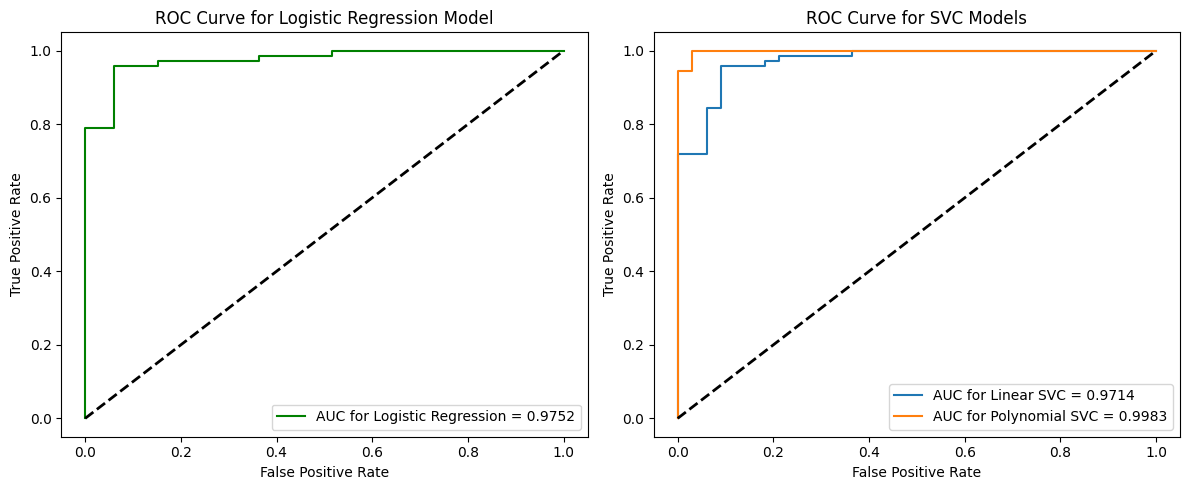

In [13]:
lin_svc = models['linear']['model']
polyn_svc = models['poly']['model']

y_pred_lin_prob = lin_svc.predict_proba(X_test)[:, 1]
y_pred_polyn_prob = polyn_svc.predict_proba(X_test)[:, 1]
y_pred_lr_prob = lr.predict_proba(X_test)[:, 1]

y_true_lb = LabelBinarizer().fit(y_test)
y_true = y_true_lb.transform(y_test)

model_predictions = {
    'Logistic Regression': y_pred_lr_prob,
    'Linear SVC': y_pred_lin_prob,
    'Polynomial SVC': y_pred_polyn_prob
}

fpr = dict()
tpr = dict()
roc_auc = dict()

for model_name, y_pred_prob in model_predictions.items():
    fpr[model_name], tpr[model_name], _ = roc_curve(y_true, y_pred_prob)
    roc_auc[model_name] = roc_auc_score(y_true, y_pred_prob)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Baseline Logistic Regression model
axs[0].plot(fpr["Logistic Regression"], tpr["Logistic Regression"], color='g', label=f'AUC for Logistic Regression = {roc_auc["Logistic Regression"]:.4f}')
axs[0].plot([0, 1], [0, 1], 'k--', linewidth=2)
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].set_title("ROC Curve for Logistic Regression Model")
axs[0].legend()

# SVC models
for model_name in ['Linear SVC', 'Polynomial SVC']:
    axs[1].plot(
        fpr[model_name], tpr[model_name], 
        label=f"AUC for {model_name} = {roc_auc[model_name]:.4f}"
        )
axs[1].plot([0, 1], [0, 1], 'k--', linewidth=2)
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve for SVC Models")
axs[1].legend()

plt.tight_layout()
plt.show()

### 3.4 Cross Validation
1. Use n-fold **cross validation** to evaluate the model, where n=10.
2. Use **KFold** cross validation to evaluate, with K = 10, shuffle.

Cross-Validation score for Logistic Regression:
[0.95238095 0.92857143 0.95238095 0.88095238 0.88095238 0.97619048
 0.82926829 0.95121951 0.87804878 0.95121951]
Mean cross-validation score: 
0.9181
KFold-cv score for Logistic Regression:
[0.95238095 0.88095238 0.92857143 0.9047619  0.88095238 0.97619048
 0.90243902 0.97560976 0.92682927 0.90243902]
KFold Mean cross-validation score for Logistic Regression: 
0.9231

Cross-Validation score for Linear SVC:
[0.95238095 0.92857143 0.95238095 0.88095238 0.85714286 0.95238095
 0.85365854 0.95121951 0.90243902 0.95121951]
Mean cross-validation score: 
0.9182
KFold-cv score for Linear SVC:
[0.95238095 0.85714286 0.92857143 0.92857143 0.85714286 0.97619048
 0.90243902 0.90243902 0.95121951 0.90243902]
KFold Mean cross-validation score for Linear SVC: 
0.9159

Cross-Validation score for Polynomial SVC:
[1.         0.95238095 1.         0.9047619  0.92857143 0.92857143
 0.95121951 1.         0.97560976 0.97560976]
Mean cross-validation score: 
0.9

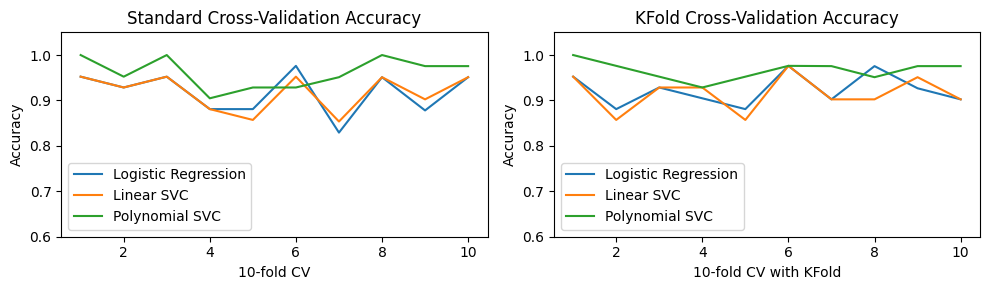

In [14]:
models = {
    'Logistic Regression': lr,
    'Linear SVC': lin_svc,
    'Polynomial SVC': polyn_svc
}
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

for model_name, model in models.items():
    # cross val score
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print(f"Cross-Validation score for {model_name}:\n{scores}")
    print(f"Mean cross-validation score: \n{scores.mean():.4f}")
    axs[0].plot(range(1, 11), scores, label=model_name)

    # KFold cross val, k=10
    kf_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(f"KFold-cv score for {model_name}:\n{kf_scores}")
    print(f"KFold Mean cross-validation score for {model_name}: \n{kf_scores.mean():.4f}\n")
    axs[1].plot(range(1, 11), kf_scores, label=model_name)

axs[0].set_ylim([0.6, 1.05])
axs[0].set_xlabel("10-fold CV")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Standard Cross-Validation Accuracy")
axs[0].legend()

axs[1].set_ylim([0.6, 1.05])
axs[1].set_xlabel("10-fold CV with KFold")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("KFold Cross-Validation Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

## 4. Model Persistence & Demo

In [15]:
# save the model to disk
models = {
    'model_lr.pkl': lr,
    'model_lin_svc.pkl': lin_svc,
    'model_polyn_svc.pkl': polyn_svc
}

for filename, model in models.items():
    with open(f'models/{filename}', 'wb') as f:
        pickle.dump(model, f)
        

In [3]:
# load the model & Demo
try:
    with open ('models/model_lr.pkl', 'rb') as f:
        model_lr = pickle.load(f)

    with open ('models/model_lin_svc.pkl', 'rb') as f:
        model_lin_svc = pickle.load(f)

    with open ('models/model_polyn_svc.pkl', 'rb') as f:
        model_polyn_svc = pickle.load(f)
    
    # You will be prompted to enter values for features
    models_demo(lr=model_lr, lin_svc=model_lin_svc, polyn_svc=model_polyn_svc)

except FileNotFoundError as e:
    print(f'Saved Models not found: {e}')


# Models Prediction Results:
Logistic Regression: ['Positive']
Linear SVC: ['Positive']
Polynomial SVC: ['Negative']

Assuming you want to quit; exiting...
